In [1]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sn

from catboost import CatBoostRegressor

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, RegressorMixin

from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

In [ ]:
subj_path = "..\\data\\Fedor\\Raw\\preproc_angles\\1\\"
data = np.load(subj_path + "0000.npz")

print(data["myo_ts"].shape)
print(data["data_angles"].shape)
print(data["data_vr"].shape)
print(data["data_myo"].shape)
print(data["std_coef"].shape)

(44452,)
(44452, 20)
(44452, 16, 4)
(44452, 6)
(1, 8)


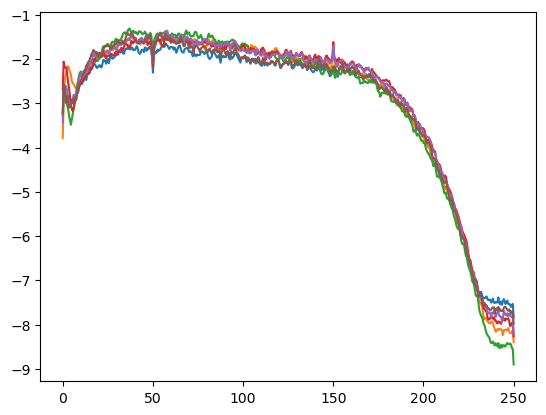

In [ ]:
fs = 500
f, pxx = sn.welch(x=data["data_myo"], axis=0, fs=fs, nperseg=int(fs * 2))

plt.figure()
plt.plot(f, np.log10(pxx))


def train_test_split(data, N_parts, num_of_part):
    N_samples = len(data)

    l_idx = int((N_samples * num_of_part) / N_parts)
    h_idx = int((N_samples * (num_of_part + 1)) / N_parts)

    data_train = np.concatenate([data[:l_idx, :], data[h_idx:,]], axis=0)
    data_test = data[l_idx:h_idx, :]

    return data_train, data_test


N_files = 4
data_list_train = list()
data_list_test = list()
label_list_train = list()
label_list_test = list()

N_parts = 10
num_of_part = 9

for i in range(N_files):

    arr = np.load(subj_path + "000" + str(i) + ".npz")

    std_coef = arr["std_coef"]
    data = arr["data_myo"]
    label = arr["data_angles"]

    data_train, data_test = train_test_split(data, N_parts, num_of_part)
    label_train, label_test = train_test_split(label, N_parts, num_of_part)

    data_list_train.append(data_train)
    data_list_test.append(data_test)

    label_list_train.append(label_train)
    label_list_test.append(label_test)


data_train = np.concatenate(data_list_train, axis=0)
data_test = np.concatenate(data_list_test, axis=0)


label_train = np.concatenate(label_list_train, axis=0)
label_test = np.concatenate(label_list_test, axis=0)

In [ ]:
windowlen = 500
timestep = 100
fs = 500

data = data_train
label = label_train

data_len = len(data)
timestep_samples = int((timestep * fs) / 1000)
windowlen_samples = int((windowlen * fs) / 1000)
start_idc = np.arange(0, data_len - windowlen_samples, timestep_samples)[:, None]
window_idc = np.arange(0, windowlen_samples)[None, :]
slice_idc = start_idc + window_idc
slice_data = data[slice_idc].transpose(0, 2, 1)
slice_label = label[start_idc[:, 0] + windowlen_samples]

In [37]:
windowlen_samples

250

In [ ]:
def slicer(data, label, fs, windowlen=500, timestep=100):
    data_len = len(data)
    timestep_samples = int((timestep * fs) / 1000)
    windowlen_samples = int((windowlen * fs) / 1000)
    start_idc = np.arange(0, data_len - windowlen_samples, timestep_samples)[:, None]
    window_idc = np.arange(0, windowlen_samples)[None, :]
    slice_idc = start_idc + window_idc
    slice_data = data[slice_idc].transpose(0, 2, 1)
    slice_label = label[start_idc[:, 0] + windowlen_samples]
    return slice_data, slice_label


X_train, y_train = slicer(data_train, label_train, fs)
X_test, y_test = slicer(data_test, label_test, fs)

pipeline1 = make_pipeline(
    Covariances("oas"), TangentSpace(metric="riemann"), LinearRegression()
)
pipeline1.fit(X_train, y_train)

pipeline2 = make_pipeline(
    Covariances("oas"),
    TangentSpace(metric="riemann"),
    MLPRegressor(
        hidden_layer_sizes=(200,), activation="relu", solver="adam", alpha=0.00001
    ),
)
pipeline2.fit(X_train, y_train)

pipeline3 = make_pipeline(
    Covariances("oas"),
    TangentSpace(metric="riemann"),
    MLPRegressor(
        hidden_layer_sizes=(400, 400), activation="relu", solver="adam", alpha=0.001
    ),
)
pipeline3.fit(X_train, y_train)


def corrcoef(x, y):
    x2 = x - np.mean(x)
    y2 = y - np.mean(y)
    normx = np.linalg.norm(x)
    normy = np.linalg.norm(y)
    return np.sum(x * y) / (normx * normy)


def corrcoef1(x, y):
    x_centered = x - np.mean(x)
    y_centered = y - np.mean(y)

    numerator = np.sum(x_centered * y_centered)
    denominator = np.sqrt(np.sum(x_centered**2)) * np.sqrt(np.sum(y_centered**2))

    if denominator == 0:
        return 0.0  # Обработка случая нулевой дисперсии

    return numerator / denominator


y_predict1 = pipeline1.predict(X_test)
y_predict2 = pipeline2.predict(X_test)
y_predict3 = pipeline3.predict(X_test)

for i in range(y_test.shape[1]):
    print(corrcoef(y_predict1[:, i], y_test[:, i]))
    print(corrcoef1(y_predict1[:, i], y_test[:, i]))
    print(np.corrcoef(y_predict1[:, i], y_test[:, i])[0, 1])
    print("-------------------------------------")
    # print(corrcoef(y_predict2[:,i],y_test[:,i]))
    # print(corrcoef(y_predict3[:,i],y_test[:,i]))

0.8246229626582618
0.8190992106528011
0.8190992106528012
-------------------------------------
0.9884834303687041
0.758043354514603
0.758043354514603
-------------------------------------
0.9320179233000828
0.8716401261518355
0.8716401261518353
-------------------------------------
0.9104893492016249
0.8803684233164693
0.8803684233164694
-------------------------------------
0.8912492139898274
0.8428740278642496
0.8428740278642496
-------------------------------------
0.98575784058935
0.8159991378864775
0.8159991378864775
-------------------------------------
0.9720013565070766
0.8885483839670226
0.8885483839670226
-------------------------------------
0.9559928617195781
0.8992777375584969
0.8992777375584969
-------------------------------------
0.8905778370263441
0.8669092528918972
0.8669092528918969
-------------------------------------
0.9543819205040402
0.9331176829400452
0.9331176829400454
-------------------------------------
0.9729043310135221
0.8816863777615431
0.88168637776154

In [5]:
X_train.shape, y_train.shape

((3195, 6, 250), (3195, 20))

In [ ]:
def slicer(data, label, fs, windowlen=500, timestep=100):
    data_len = len(data)
    timestep_samples = int((timestep * fs) / 1000)
    windowlen_samples = int((windowlen * fs) / 1000)
    start_idc = np.arange(0, data_len - windowlen_samples, timestep_samples)[:, None]
    window_idc = np.arange(0, windowlen_samples)[None, :]
    slice_idc = start_idc + window_idc
    slice_data = data[slice_idc].transpose(0, 2, 1)
    slice_label = label[start_idc[:, 0] + windowlen_samples]
    return slice_data, slice_label


# Создание и обучение пайплайнов
pipelines = {
    "Linear Regression": make_pipeline(
        Covariances("oas"), TangentSpace(metric="riemann"), LinearRegression()
    ),
    "MLP (200)": make_pipeline(
        Covariances("oas"),
        TangentSpace(metric="riemann"),
        MLPRegressor(
            hidden_layer_sizes=(200,), activation="relu", solver="adam", alpha=0.001
        ),
    ),
    "MLP (400x400)": make_pipeline(
        Covariances("oas"),
        TangentSpace(metric="riemann"),
        MLPRegressor(
            hidden_layer_sizes=(400, 400), activation="relu", solver="adam", alpha=0.001
        ),
    ),
}

# Обучение всех пайплайнов
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)


# Функция для вычисления корреляции с обработкой нулевой дисперсии
def corrcoef(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0
    return np.corrcoef(x, y)[0, 1]


# Вычисление метрик для всех пайплайнов
results = {}

for name, pipeline in pipelines.items():
    y_pred = pipeline.predict(X_test)
    correlations = []

    for i in range(y_test.shape[1]):
        try:
            corr = corrcoef(y_pred[:, i], y_test[:, i])
            correlations.append(corr)
        except:
            correlations.append(0.0)

    results[name] = {
        "all_correlations": correlations,
        "mean_correlation": np.nanmean(correlations),
        "std_correlation": np.nanstd(correlations),
    }

# Вывод результатов
for name, metrics in results.items():
    print(f"{name}:")
    print(
        f'  Mean correlation: {metrics["mean_correlation"]:.3f} ± {metrics["std_correlation"]:.3f}'
    )
    print(
        f'  Individual correlations: {[f"{c:.3f}" for c in metrics["all_correlations"]]}\n'
    )

Linear Regression:
  Mean correlation: 0.873 ± 0.041
  Individual correlations: ['0.819', '0.758', '0.872', '0.880', '0.843', '0.816', '0.889', '0.899', '0.867', '0.933', '0.882', '0.898', '0.876', '0.881', '0.882', '0.903', '0.837', '0.948', '0.888', '0.883']

MLP (200):
  Mean correlation: 0.887 ± 0.067
  Individual correlations: ['0.921', '0.793', '0.934', '0.937', '0.903', '0.684', '0.914', '0.922', '0.905', '0.767', '0.911', '0.918', '0.913', '0.795', '0.909', '0.923', '0.892', '0.945', '0.920', '0.926']

MLP (400x400):
  Mean correlation: 0.906 ± 0.043
  Individual correlations: ['0.931', '0.856', '0.932', '0.934', '0.913', '0.764', '0.914', '0.922', '0.916', '0.839', '0.909', '0.918', '0.920', '0.861', '0.906', '0.919', '0.931', '0.955', '0.940', '0.939']



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.covariance import OAS

# Проверка доступности CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


class MLPRegressor(nn.Module):
    def __init__(self, input_dim=36, hidden_dims=(400, 400), output_dim=20):
        super().__init__()
        layers = []
        prev_dim = input_dim

        # Динамическое построение слоев
        for i, h_dim in enumerate(hidden_dims):
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))  # Добавим регуляризацию
            prev_dim = h_dim

        layers.append(nn.Linear(prev_dim, output_dim))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class RiemannianNN(nn.Module):
    def __init__(self, n_channels=6, output_dim=20):
        super().__init__()
        self.n_channels = n_channels
        input_dim = n_channels**2  # 6x6 = 36

        # Замена линейного слоя на MLPRegressor
        self.mlp = MLPRegressor(
            input_dim=input_dim, hidden_dims=(400, 400), output_dim=output_dim
        ).to(device)

        # Инициализация весов для MLP
        for layer in self.mlp.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight, gain=1e-3)
                nn.init.constant_(layer.bias, 0.0)

        self.oas = OAS(store_precision=True)
        self.ref_cov = None
        self.eps = 1e-3

    def _riemannian_features(self, X):
        batch_size = X.size(0)

        # Нормализация входных данных на GPU
        X_normalized = (X - X.mean(dim=2, keepdim=True)) / (
            X.std(dim=2, keepdim=True) + 1e-8
        )

        # Вычисление ковариационных матриц с переносом данных на CPU для OAS
        covs = torch.zeros(batch_size, self.n_channels, self.n_channels, device=device)
        for i in range(batch_size):
            self.oas.fit(X_normalized[i].cpu().numpy().T)
            cov = self.oas.covariance_
            cov_reg = cov + np.eye(cov.shape[0]) * self.eps
            covs[i] = torch.tensor(cov_reg, device=device)

        # Расчет эталонной матрицы на GPU
        if self.ref_cov is None:
            self.ref_cov = torch.mean(covs, dim=0)
            self.ref_cov += torch.eye(self.n_channels, device=device) * self.eps

        # Ускоренное спектральное разложение на GPU
        U, S, V = torch.svd(self.ref_cov)
        S = torch.clamp(S, min=1e-6)
        sqrt_S_inv = torch.diag(torch.pow(S, -0.5))
        logm_ref = U @ sqrt_S_inv @ V.T

        # Векторизованные вычисления на GPU
        transformed = logm_ref @ covs @ logm_ref.transpose(-1, -2)
        transformed += self.eps * torch.eye(self.n_channels, device=device)

        # Пакетное SVD на GPU
        U_t, S_t, V_t = torch.svd(transformed)
        log_S = torch.log(torch.clamp(S_t, min=1e-6))
        logm = U_t @ torch.diag_embed(log_S) @ V_t.transpose(-1, -2)

        return logm.view(batch_size, -1)

    def forward(self, x):
        features = self._riemannian_features(x)
        return self.mlp(features)


# Инициализация модели на GPU
model = RiemannianNN(n_channels=6, output_dim=20).to(device)

# Преобразование данных в тензоры с переносом на GPU
X_train_tensor = torch.tensor(X_train, device=device).float()
y_train_tensor = torch.tensor(y_train, device=device).float()
X_test_tensor = torch.tensor(X_test, device=device).float()
y_test_tensor = torch.tensor(y_test, device=device).float()

# Оптимизированный оптимизатор для GPU
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.MSELoss()

# Обучение с использованием DataLoader для эффективного использования памяти
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

for epoch in range(100):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Валидация на GPU
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Предсказание на тестовых данных с переносом обратно на CPU
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test_tensor).cpu().numpy()

# Расчет корреляций
correlations_nn = [np.corrcoef(y_pred_nn[:, i], y_test[:, i])[0, 1] for i in range(20)]

# Вывод результатов
print("\nРезультаты нейросетевой модели на GPU:")
print(
    f"Средняя корреляция: {np.mean(correlations_nn):.3f} ± {np.std(correlations_nn):.3f}"
)

Using device: cuda
Epoch 1, Loss: 0.0774, Val Loss: 0.0786
Epoch 2, Loss: 0.0353, Val Loss: 0.0529
Epoch 3, Loss: 0.0232, Val Loss: 0.0503
Epoch 4, Loss: 0.0186, Val Loss: 0.0423
Epoch 5, Loss: 0.0337, Val Loss: 0.0390
Epoch 6, Loss: 0.0216, Val Loss: 0.0361
Epoch 7, Loss: 0.0170, Val Loss: 0.0383
Epoch 8, Loss: 0.0143, Val Loss: 0.0372
Epoch 9, Loss: 0.0142, Val Loss: 0.0358
Epoch 10, Loss: 0.0267, Val Loss: 0.0357
Epoch 11, Loss: 0.0086, Val Loss: 0.0344
Epoch 12, Loss: 0.0181, Val Loss: 0.0337
Epoch 13, Loss: 0.0181, Val Loss: 0.0313
Epoch 14, Loss: 0.0249, Val Loss: 0.0397
Epoch 15, Loss: 0.0133, Val Loss: 0.0360
Epoch 16, Loss: 0.0177, Val Loss: 0.0351
Epoch 17, Loss: 0.0141, Val Loss: 0.0323
Epoch 18, Loss: 0.0255, Val Loss: 0.0397
Epoch 19, Loss: 0.0150, Val Loss: 0.0326
Epoch 20, Loss: 0.0171, Val Loss: 0.0330
Epoch 21, Loss: 0.0379, Val Loss: 0.0375
Epoch 22, Loss: 0.0205, Val Loss: 0.0337
Epoch 23, Loss: 0.0108, Val Loss: 0.0398
Epoch 24, Loss: 0.0145, Val Loss: 0.0362
Epoch 

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.covariance import OAS
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace


class RiemannianNN(nn.Module):
    def __init__(self, n_channels=6, output_dim=20):
        super().__init__()
        self.n_channels = n_channels

        # Sklearn-компоненты для препроцессинга
        self.cov_estimator = Covariances(estimator="oas")
        self.tangent_space = TangentSpace(metric="riemann")

        # Нейросетевая часть
        self.mlp = MLPRegressor(
            input_dim=n_channels
            * (n_channels + 1)
            // 2,  # Размерность касательного пространства
            hidden_dims=(400, 400),
            output_dim=output_dim,
        )

    def _preprocess(self, X):
        """Вычисление признаков через Covariances + TangentSpace"""
        # X shape: (batch, channels, time)
        X_np = X.cpu().numpy().transpose(0, 2, 1)  # -> (batch, time, channels)

        # Вычисление ковариационных матриц
        covs = self.cov_estimator.fit_transform(X_np)

        # Преобразование в касательное пространство
        features = self.tangent_space.fit_transform(covs)

        return torch.tensor(features, device=X.device).float()

    def forward(self, x):
        features = self._preprocess(x)
        return self.mlp(features)


class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims=(400, 400), output_dim=20):
        super().__init__()
        layers = []
        prev_dim = input_dim

        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            prev_dim = h_dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


# Пример использования
model = RiemannianNN(n_channels=6, output_dim=20).to(device)

# Преобразование данных в тензоры с переносом на GPU
X_train_tensor = torch.tensor(X_train, device=device).float()
y_train_tensor = torch.tensor(y_train, device=device).float()
X_test_tensor = torch.tensor(X_test, device=device).float()
y_test_tensor = torch.tensor(y_test, device=device).float()

# Оптимизированный оптимизатор для GPU
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.MSELoss()

# Обучение с использованием DataLoader для эффективного использования памяти
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

for epoch in range(50):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Валидация на GPU
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Предсказание на тестовых данных с переносом обратно на CPU
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test_tensor).cpu().numpy()

# Расчет корреляций
correlations_nn = [np.corrcoef(y_pred_nn[:, i], y_test[:, i])[0, 1] for i in range(20)]

# Вывод результатов
print("\nРезультаты нейросетевой модели на GPU:")
print(
    f"Средняя корреляция: {np.mean(correlations_nn):.3f} ± {np.std(correlations_nn):.3f}"
)

LinAlgError: Internal Error.

In [ ]:
X_train.shape, y_train.shape

((3195, 6, 250), (3195, 20))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.covariance import OAS


class RiemannianNN(nn.Module):
    def __init__(self, n_channels=6, output_dim=20):
        super().__init__()
        self.n_channels = n_channels
        self.fc = nn.Linear(n_channels**2, output_dim)

        # Инициализация весов
        nn.init.xavier_normal_(self.fc.weight, gain=1e-3)
        nn.init.constant_(self.fc.bias, 0.0)

        self.oas = OAS(store_precision=True)
        self.ref_cov = None
        self.eps = 1e-3

    def _riemannian_features(self, X):
        batch_size = X.size(0)
        device = X.device

        # Нормализация входных данных
        X_normalized = (X - X.mean(dim=2, keepdim=True)) / (
            X.std(dim=2, keepdim=True) + 1e-8
        )

        # Вычисление ковариационных матриц
        covs = torch.zeros(batch_size, self.n_channels, self.n_channels, device=device)
        for i in range(batch_size):
            self.oas.fit(X_normalized[i].cpu().numpy().T)
            cov = self.oas.covariance_
            cov_reg = cov + np.eye(cov.shape[0]) * self.eps
            covs[i] = torch.tensor(cov_reg, device=device)

        # Расчет эталонной матрицы
        if self.ref_cov is None:
            self.ref_cov = torch.mean(covs, dim=0)
            self.ref_cov += torch.eye(self.n_channels, device=device) * self.eps

        # Спектральное разложение эталонной матрицы
        U, S, V = torch.svd(self.ref_cov)
        S = torch.clamp(S, min=1e-6)
        sqrt_S_inv = torch.diag(torch.pow(S, -0.5))
        logm_ref = U @ sqrt_S_inv @ V.T

        # Вычисление признаков
        features = []
        for i in range(batch_size):
            transformed = logm_ref @ covs[i] @ logm_ref.T

            # SVD для логарифма
            U_t, S_t, V_t = torch.svd(
                transformed + self.eps * torch.eye(self.n_channels, device=device)
            )
            log_S = torch.log(torch.clamp(S_t, min=1e-6))
            logm = U_t @ torch.diag(log_S) @ V_t.T

            features.append(logm.flatten())

        return torch.stack(features)

    def forward(self, x):
        features = self._riemannian_features(x)
        return self.fc(features)


# Инициализация модели
model = RiemannianNN(n_channels=6, output_dim=20)

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()

# Гиперпараметры
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
criterion = nn.MSELoss()
batch_size = 64
epochs = 100

# Цикл обучения
for epoch in range(epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i : i + batch_size]
        batch_y = y_train_tensor[i : i + batch_size]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Валидация
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, torch.tensor(y_test).float())
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Предсказание на тестовых данных
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test_tensor).numpy()

# Расчет корреляций для PyTorch модели
correlations_nn = [np.corrcoef(y_pred_nn[:, i], y_test[:, i])[0, 1] for i in range(20)]

# Сравнение с sklearn-моделями
results = {
    "PyTorch NN": {
        "mean_corr": np.mean(correlations_nn),
        "std_corr": np.std(correlations_nn),
        "all_corrs": correlations_nn,
    },
    # ... результаты sklearn-моделей из предыдущего кода
}

print("\nСравнение моделей:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(
        f"  Средняя корреляция: {metrics['mean_corr']:.3f} ± {metrics['std_corr']:.3f}"
    )

Epoch 1, Loss: 0.1520, Val Loss: 0.3491
Epoch 2, Loss: 0.1312, Val Loss: 0.3279
Epoch 3, Loss: 0.1135, Val Loss: 0.3091
Epoch 4, Loss: 0.0983, Val Loss: 0.2922
Epoch 5, Loss: 0.0852, Val Loss: 0.2769
Epoch 6, Loss: 0.0739, Val Loss: 0.2630
Epoch 7, Loss: 0.0641, Val Loss: 0.2504
Epoch 8, Loss: 0.0556, Val Loss: 0.2388
Epoch 9, Loss: 0.0483, Val Loss: 0.2281
Epoch 10, Loss: 0.0420, Val Loss: 0.2184
Epoch 11, Loss: 0.0366, Val Loss: 0.2093
Epoch 12, Loss: 0.0320, Val Loss: 0.2010
Epoch 13, Loss: 0.0281, Val Loss: 0.1932
Epoch 14, Loss: 0.0247, Val Loss: 0.1860
Epoch 15, Loss: 0.0219, Val Loss: 0.1792
Epoch 16, Loss: 0.0195, Val Loss: 0.1730
Epoch 17, Loss: 0.0176, Val Loss: 0.1671
Epoch 18, Loss: 0.0159, Val Loss: 0.1616
Epoch 19, Loss: 0.0146, Val Loss: 0.1564
Epoch 20, Loss: 0.0135, Val Loss: 0.1515
Epoch 21, Loss: 0.0127, Val Loss: 0.1469
Epoch 22, Loss: 0.0120, Val Loss: 0.1425
Epoch 23, Loss: 0.0115, Val Loss: 0.1384
Epoch 24, Loss: 0.0112, Val Loss: 0.1345
Epoch 25, Loss: 0.0109, V

In [ ]:
class RecurrentWrapper(BaseEstimator, RegressorMixin):
    """
    Рекуррентная обертка для моделей. Использует историю предсказаний
    как дополнительный вход для следующего шага.
    """

    def __init__(self, base_model, lookback=3):
        self.base_model = base_model
        self.lookback = lookback  # Сколько прошлых предсказаний учитывать
        self.history = None

    def fit(self, X, y):
        # Добавляем фиктивные исторические данные для обучения
        X_aug = self._add_history(X, init_value=0.0)
        self.base_model.fit(X_aug, y)
        return self

    def predict(self, X):
        predictions = []
        self.history = np.zeros((X.shape[0], self.lookback, y_train.shape[1]))

        for i in range(X.shape[0]):
            # Объединяем текущие данные с историей
            X_aug = np.concatenate([X[i].flatten(), self.history[i].flatten()]).reshape(
                1, -1
            )

            # Делаем предсказание
            pred = self.base_model.predict(X_aug)
            predictions.append(pred)

            # Обновляем историю
            if i < X.shape[0] - 1:
                self.history[i + 1] = np.roll(self.history[i], shift=-1, axis=0)
                self.history[i + 1, -1] = pred

        return np.vstack(predictions)

    def _add_history(self, X, init_value=0.0):
        """Добавление истории к данным для обучения"""
        X_aug = []
        history = np.full((self.lookback, y_train.shape[1]), init_value)

        for x in X:
            x_flat = x.flatten()
            hist_flat = history.flatten()
            X_aug.append(np.concatenate([x_flat, hist_flat]))
            history = np.roll(history, shift=-1, axis=0)
            history[-1] = init_value

        return np.array(X_aug)


# Модифицированный пайплайн с рекуррентной оберткой
pipeline1 = make_pipeline(
    Covariances("oas"),
    TangentSpace(metric="riemann"),
    RecurrentWrapper(LinearRegression(), lookback=3),
)

pipeline2 = make_pipeline(
    Covariances("oas"),
    TangentSpace(metric="riemann"),
    RecurrentWrapper(MLPRegressor(hidden_layer_sizes=(200,)), lookback=3),
)

# Обучение и предсказание (остальной код остается как в оригинале)
pipeline1.fit(X_train, y_train)
y_pred = pipeline1.predict(X_test)

correlations = []

for i in range(y_test.shape[1]):
    try:
        corr = corrcoef(y_pred[:, i], y_test[:, i])
        correlations.append(corr)
    except:
        correlations.append(0.0)

{
    # 'all_correlations': correlations,
    "mean_correlation": np.nanmean(correlations),
    "std_correlation": np.nanstd(correlations),
}

NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

C:\Users\laput\AppData\Local\Temp\ipykernel_29904\1971986445.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


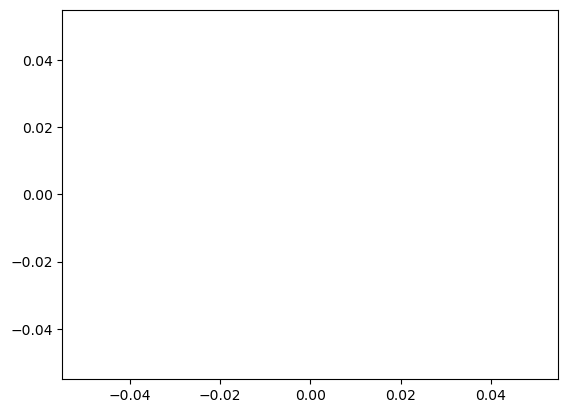

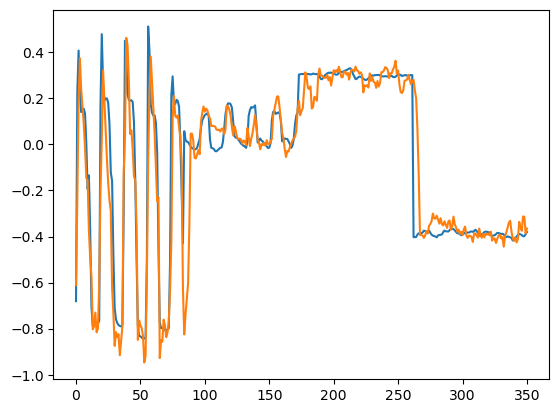

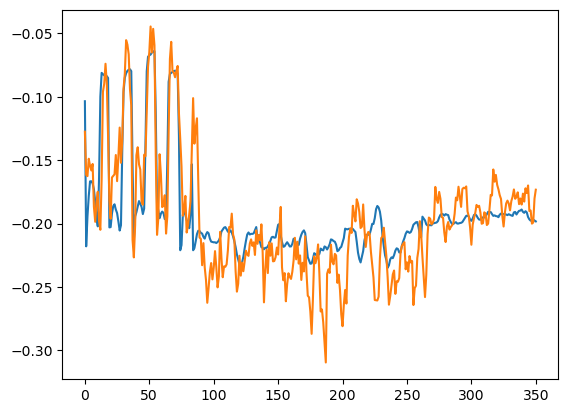

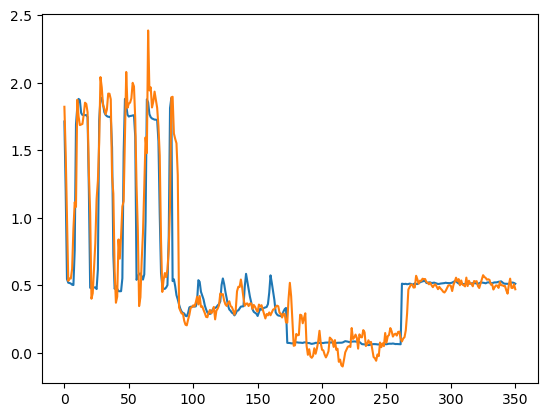

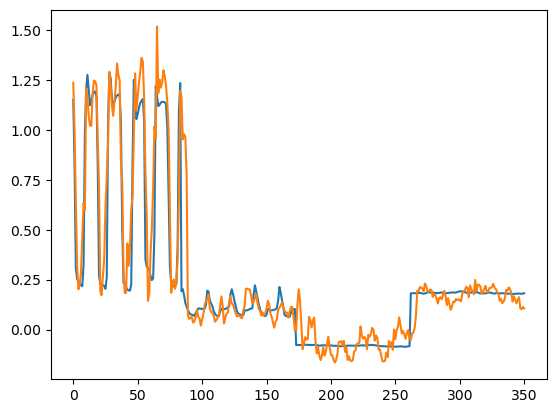

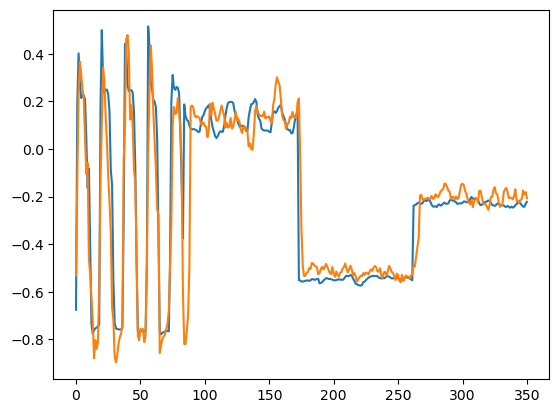

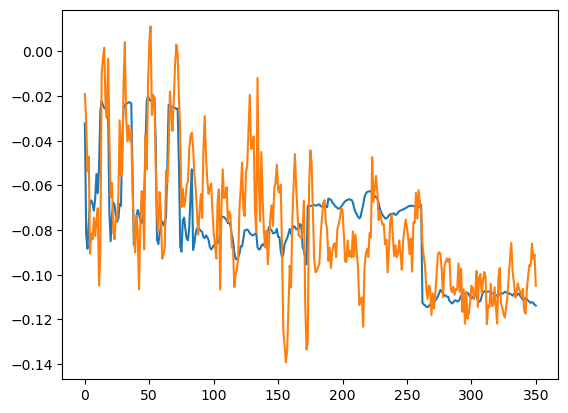

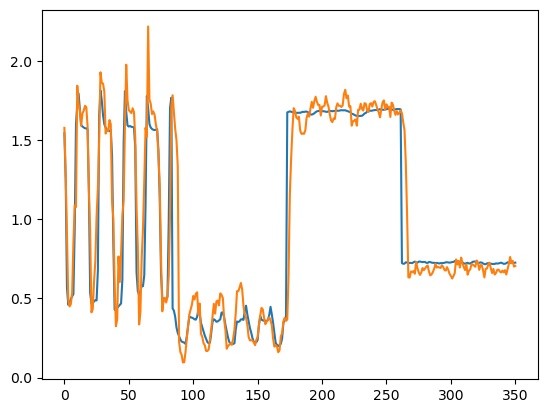

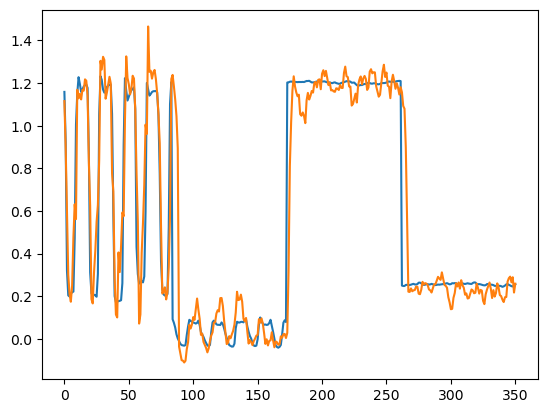

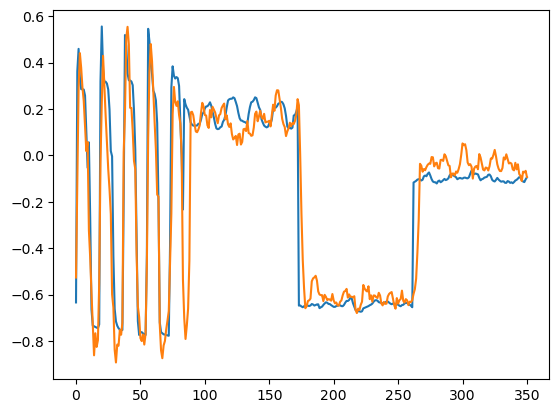

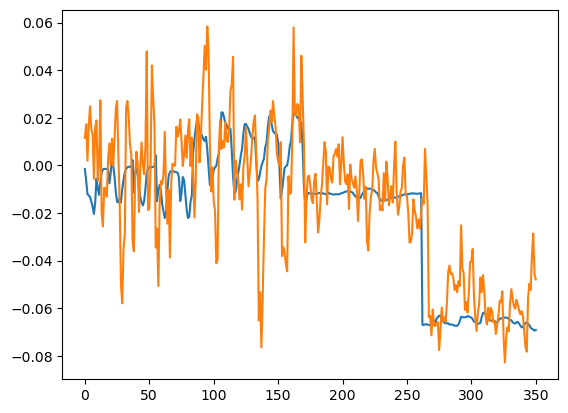

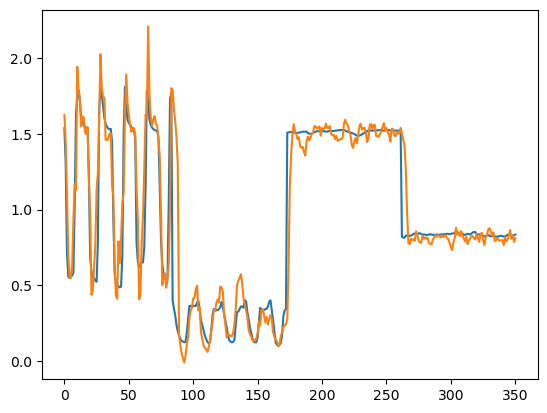

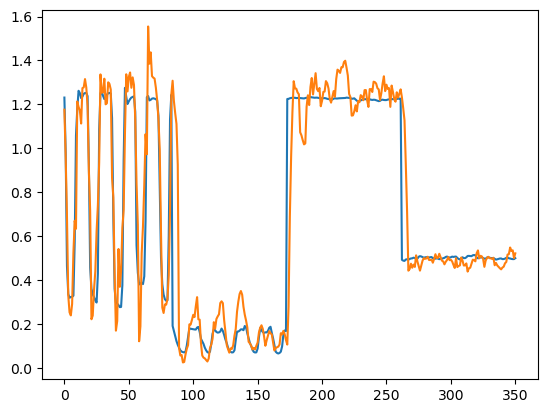

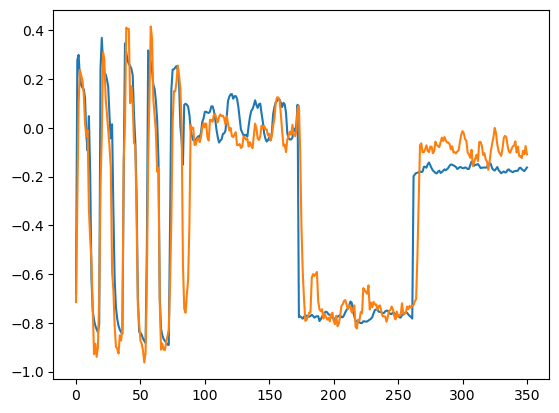

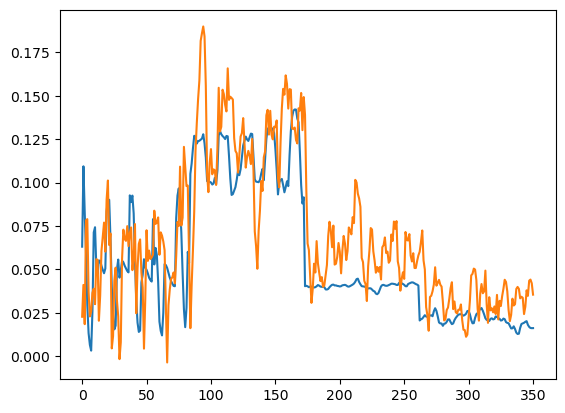

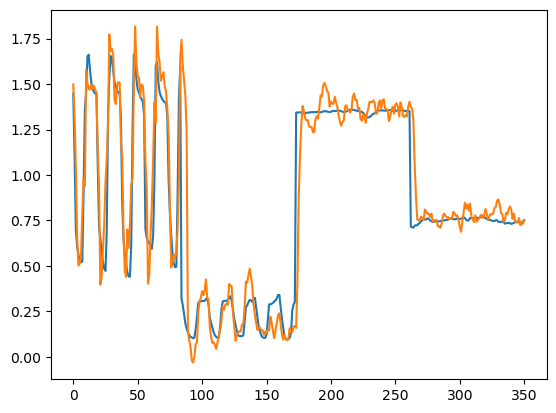

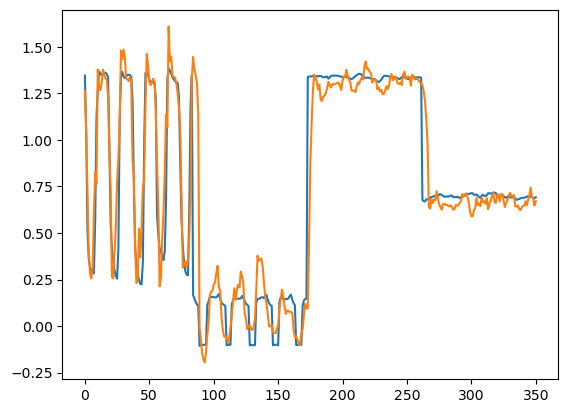

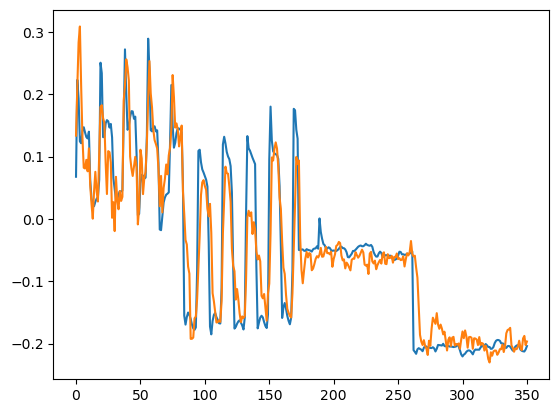

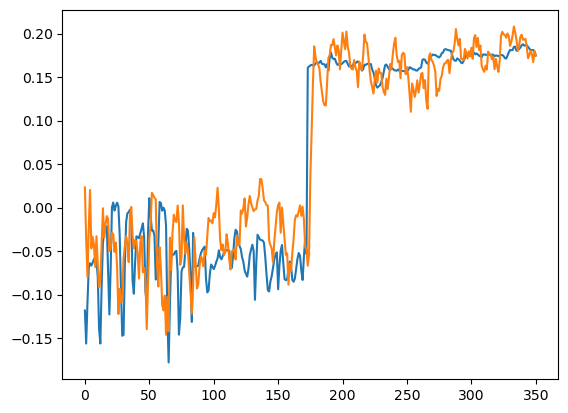

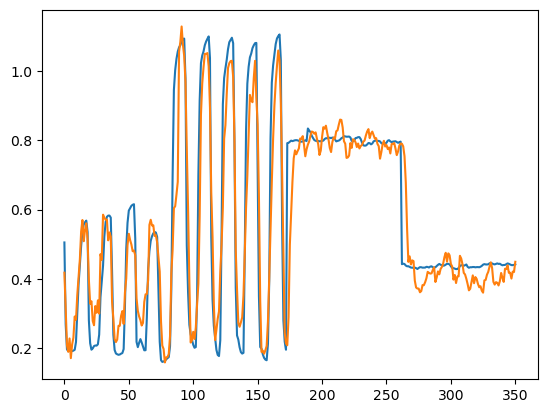

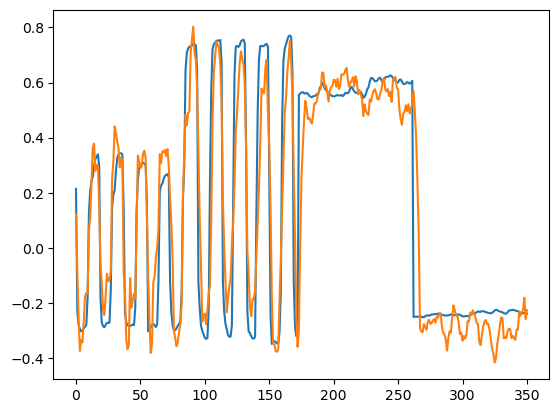

In [ ]:
y_predict = pipeline2.predict(X_test)

plt.figure()
plt.plot(y_predict[int(100 * fs / 100) : int(400 * fs / 100)])

# joblib.dump(pipeline3, 'real_time_regression/Fedor_TEST.pickle')
# np.save('real_time_regression/preproc_params_Fedor_TEST.npy', std_coef)

for i in range(y_test.shape[1]):

    plt.figure()
    plt.plot(y_test[:, i])
    plt.plot(y_predict[:, i])